## Test object detection using remote camera server, cleint

#### Run shared detector on bash
```bash
python3 /home/jhkim/Projects/3D_Object_Detection/src/scripts/demo_2022/demo_utils/shared_detector.py
```


#### Run remote camera streaming server (robot-side pc)
```bash
python3 cam_grpc_sever.py
```

In [1]:
import os
import sys
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

os.chdir(os.path.join(os.environ["HOME"], "Projects/3D_Object_Detection/src"))
sys.path.append(os.path.join(os.environ["HOME"], "Projects/3D_Object_Detection/src"))
sys.path.append(os.path.join(os.environ["HOME"], "Projects/3D_Object_Detection/src/scripts/demo_202210"))

import grpc
from pkg.detector.grpc_cam.RemoteCam_pb2 import *
from pkg.detector.grpc_cam.RemoteCam_pb2_grpc import *
from pkg.detector.ICP_Detector import *

CONNECT_CAM = True
CONNECT_ROBOT = True
ENABLE_DETECT = True

In [2]:
from pkg.utils.rotation_utils import *
from indy_utils_dh.indydcp_client import IndyDCPClient
# from indy_utils.indydcp_client? import IndyDCPClient
from scipy.spatial.transform import Rotation

server_ip = "192.168.1.28"  # check always the robot ip
# robot_name = "NRMK-Indy7"
robot_name = "NRMK-IndyRP2"

# generate indydcp client
indy = IndyDCPClient(server_ip, robot_name)


# from geometry_msgs.msg import Point
# from controller.kiro_tool import *
# from controller.move_robot import move_joint_traj, move_raw_joint_traj
# from utils.traj_utils import simplify_traj
# from utils.kinematic_utils import *
# from controller.indy_utils import *
# from compliant_controller_client import *

In [3]:
indy.connect()
indy.reset_robot()
indy.disconnect()

Connect: Server IP (192.168.1.28)


In [4]:
# check 7-DOF indy working
indy.connect()
jpos = indy.get_joint_pos()
indy.disconnect()
print("Current Joint Pos:")
print(jpos)

Connect: Server IP (192.168.1.28)
Current Joint Pos:
[-3.6835523873323712, 82.27711070668155, 4.586292613636666, -68.95714121417035, 17.63098990563235, -84.65172493812439, 6.212115901531968]


## Detector Client 

In [6]:
# generate Detector Client
detector = Detector_Client()

======= Initialize Done =======


In [7]:
# get camera configuraiton
config = detector.get_camera_config()
print("Camera Matrix: ")
print(config[0])
print("\nDist Coeffs: ")
print(config[1])
print("\nDepth Scale: ")
print(config[2])

Camera Matrix: 
[[ 902.29681396    0.          643.14813232]
 [   0.          902.0020752   379.35632324]
 [   0.            0.            1.        ]]

Dist Coeffs: 
[ 0.16663134 -0.5350312   0.00116923  0.0008499   0.47189599]

Depth Scale: 
0.000250000011874


 ======= Success to receive color, depth image =======


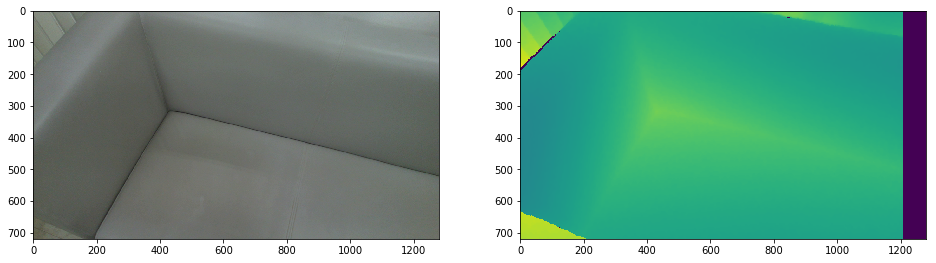

In [63]:
# get color, depth image
color, depth = detector.get_image()

# show color, depth image
fig = plt.figure(figsize=(16,9))
plt.subplot(1,2,1)
plt.imshow(color[:,:,[2,1,0]])
plt.subplot(1,2,2)
plt.imshow(depth)

### Object Detection through Swin-Transformer Cascade Mask RCNN

#### Mask RCNN

In [10]:
# shared detector
from pkg.detector.shared_detector import SharedDetectorGenerator
# from scripts.demo_202208.cam_stream_grpc.demo_utils.shared_detector import SharedDetectorGenerator
sd = SharedDetectorGenerator(tuple(reversed(detector.img_dim))+(3,))()

if ENABLE_DETECT:
    sd.init()
    detector.set_shared_detector(sd)

In [52]:
# inference through CasCade MaskRCNN
mask_out_list = detector.inference(sd, color)
sofa_idx = 57
refrigerator_idx = 72

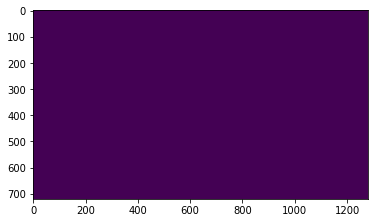

In [53]:
plt.imshow(mask_out_list[57])

#### ICP

In [11]:
##
# @brief   camera coordinate offset w.r.t tcp
def get_camera_offset():
    T = np.identity(4)
    T[:3,:3] = Rot_axis(3, -np.pi/2)
    T[:3,3] = np.array([-0.066,0,0.073])
#     T_6v = np.array([[0, 1, 0, -0.066],
#                  [-1,  0, 0, 0],
#                  [0,  0, 1, 0.073],
#                  [0,  0, 0, 1]]) # link6 to camera
    return T

In [47]:
# Read current robot state (joint value)

if CONNECT_ROBOT:
    indy.connect()
    pos_cur_deg = indy.get_joint_pos()
    print("Current robot pos[deg]:")
    print(pos_cur_deg)
    pos_cur = np.deg2rad(pos_cur_deg)
    indy.disconnect()
else:
    print("Robot is not connected!")

Connect: Server IP (192.168.1.28)
Current robot pos[deg]:
[56.99970339940975, 0.0005447766012397053, -0.0, -44.99972761170234, -0.00038071434096537165, -92.00049069848997, -0.0003263265779703185]


In [50]:
indy.connect()
indy.joint_move_by([-3,0,0,0,0,0,0])
indy.disconnect()

Connect: Server IP (192.168.1.28)


In [61]:
# VIEW_POS_LEFT = [110, 0., 0, -55, 0., -92, 0.]
# VIEW_POS_RIGHT = [60, 0., 0, -45, 0., -92, 0.]
# VIEW_POS_MIDDLE = [90, 0., 0., -60, 0., -92, 0.]

VIEW_POS_LEFT = [110, -2., 0, -55, 0., -92, 0.]
VIEW_POS_RIGHT = [57, 0., 0, -45, 0., -92, 0.]
VIEW_POS_MIDDLE = [87, 0., 0., -60, 0., -92, 0.]

In [14]:
# sofa left
indy.connect()
indy.joint_move_to(VIEW_POS_LEFT)
indy.wait_for_move_finish()
indy.disconnect()

Connect: Server IP (192.168.1.28)
Move finished!


In [113]:
# sofa middle
indy.connect()
indy.joint_move_to(VIEW_POS_MIDDLE)
indy.wait_for_move_finish()
indy.disconnect()

Connect: Server IP (192.168.1.28)
Move finished!


In [119]:
# sofa right
indy.connect()
indy.joint_move_to(VIEW_POS_RIGHT)
indy.wait_for_move_finish()
indy.disconnect()

Connect: Server IP (192.168.1.28)
Move finished!


In [99]:
# indy.connect()
# indy.joint_move_by([5,0,0,5,0,0,0])
# indy.disconnect()

In [120]:
# get camera location (Tc)

if CONNECT_ROBOT:
    indy.connect()
    tPos = indy.get_task_pos()
    indy.disconnect()
    tPos[3:6] = np.deg2rad(tPos[3:6])
    tPos = (tPos[:3], tPos[3:6])
    T = T_xyzrpy(tPos)
    Toff = get_camera_offset()
    Tc = np.matmul(T, Toff)
    T_cb = np.linalg.inv(Tc)
else:
    Tc = np.identity(4)
    T_cb = np.linalg.inv(Tc)
print(Tc)

Connect: Server IP (192.168.1.28)
[[ 0.85656184 -0.38292503  0.34593388  0.41761898]
 [-0.51602393 -0.62960881  0.58078575  0.33725698]
 [-0.00459437 -0.67598903 -0.73689735  0.81974744]
 [ 0.          0.          0.          1.        ]]


In [100]:
# # load object info
# from pkg.detector.config import *
# obj_info_dict = get_obj_info()

# micp_bed = MultiICP_Obj(obj_info_dict["bed"])
# micp_closet = MultiICP_Obj(obj_info_dict["closet"])
# micp_sofa = MultiICP_Obj(obj_info_dict["couch"])
# micp_refri = MultiICP_Obj(obj_info_dict["refrigerator"])


# micp_dict = {"bed": micp_bed, "closet": micp_closet, "couch": micp_sofa, "refrigerator":micp_refri}

# # initial guess for ICP

# Tbo_bed = np.identity(4)
# Tbo_closet = np.identity(4)
# Tbo_sofa = np.identity(4)
# Tbo_refri = np.identity(4)

# initial_list = {"bed":Tbo_bed, "closet":Tbo_closet, "couch":Tbo_sofa, "refrigerator":Tbo_refri,}

# detector.set_config(micp_dict, initial_list)

# # detector.set_merge_mask(merge=True)
# # detector.set_inlier_ratio(ratio=0.02)
# # detector.detect(sd, Tc, "couch", visualize=True)

#### plane detection

In [121]:
# load object info
from pkg.detector.config import *
obj_info_dict = get_obj_info()

micp_bed = MultiICP_Obj(obj_info_dict["bed"])
micp_closet = MultiICP_Obj(obj_info_dict["closet"])
micp_sofa = MultiICP_Obj(obj_info_dict["couch"])
micp_refri = MultiICP_Obj(obj_info_dict["refrigerator"])


micp_dict = {"bed": micp_bed, "closet": micp_closet, "couch": micp_sofa, "refrigerator":micp_refri}

In [122]:
detector.set_config(micp_dict, initial_list)

In [123]:
detector.set_ICP_thres(thres_ICP=0.1)
T = detector.detect_plane(name_mask="couch", visualize=True)

[INFO] name_mask is couch
 ======= Success to receive color, depth image =======
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.913176e-02, and correspondence_set size of 8661
Access transformation to get result.
Transformation is:
[[ 0.86829057 -0.21635023  0.44639003 -0.05869799]
 [-0.38076451 -0.86745744  0.3202124  -0.00652915]
 [ 0.31794632 -0.44800689 -0.8355836   1.26749663]
 [ 0.          0.          0.          1.        ]]
Total ICP Transformation is:
[[ 0.86829057 -0.21635023  0.44639003 -0.05869799]
 [-0.38076451 -0.86745744  0.3202124  -0.00652915]
 [ 0.31794632 -0.44800689 -0.8355836   1.26749663]
 [ 0.          0.          0.          1.        ]]
Inlier ratio: 0.0967810026385


In [18]:
T

array([[ 0.99981304,  0.00547823, -0.01854394,  0.00274786],
       [-0.0033833 , -0.89466939, -0.44671605,  0.01395366],
       [-0.01903791,  0.44669528, -0.89448359,  0.85908536],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [112]:
pcd_left = copy.deepcopy(micp_sofa.pcd)
Tc_left = Tc

In [118]:
pcd_middle = copy.deepcopy(micp_sofa.pcd)
Tc_middle = Tc

In [124]:
pcd_right = copy.deepcopy(micp_sofa.pcd)
Tc_right = Tc

In [125]:
# sofa pcd conversion
Toff1 = np.matmul(np.linalg.inv(Tc_middle), Tc_left)
pts1 = np.asarray(pcd_left.points)
pts1_converted = np.matmul(Toff1[:3, :3], pts1.T).T + Toff1[:3, 3]

pcd1_converted = o3d.geometry.PointCloud()
pcd1_converted.points = o3d.utility.Vector3dVector(pts1_converted)

In [126]:
# sofa pcd conversion
Toff2 = np.matmul(np.linalg.inv(Tc_middle), Tc_right)
pts2 = np.asarray(pcd_right.points)
pts2_converted = np.matmul(Toff2[:3, :3], pts2.T).T + Toff2[:3, 3]

pcd2_converted = o3d.geometry.PointCloud()
pcd2_converted.points = o3d.utility.Vector3dVector(pts2_converted)

In [134]:
pcd_total = pcd_middle + pcd1_converted + pcd2_converted

In [135]:
pcd_total, _ = pcd_total.remove_radius_outlier(20, 0.05)

In [136]:
FOR_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05, origin=(0,0,0))
o3d.visualization.draw_geometries([pcd_total, FOR_origin])

In [110]:
plane = o3d.geometry.TriangleMesh.create_box(width=0.6, height=0.3, depth=0.001)
plane.translate((-0.3, -0.15, 0))
# plane.rotate(Rot_axis(1,np.pi))
FOR_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05, origin=(0,0,0))

In [111]:
o3d.visualization.draw_geometries([micp_sofa.pcd, FOR_origin, plane])